In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Add, LSTM, Activation, Flatten, Dropout, SimpleRNN, Bidirectional, Conv1D, GRU, Input, BatchNormalization
from keras.models import Model
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
from googlefinance.client import get_price_data, get_prices_data, get_prices_time_data
import fix_yahoo_finance as yf
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
%matplotlib inline

In [3]:
def preprocess(Stock,start_date,open_close,seq_len=20):
#     param = {
#         'q': Stock, # Stock symbol (ex: "AAPL")
#         'i': "86400", # Interval size in seconds ("86400" = 1 day intervals)
#         # Stock exchange symbol on which stock is traded (ex: "NASD")
#          'p':'5Y'# Period (Ex: "1Y" = 1 year)
#     }
#     data = yf.download(Stock,start_date)
    data = pd.read_csv(Stock+'.csv')
    data['Close'].replace(0, np.nan, inplace=True)
    data['Close'].fillna(method='ffill', inplace=True)
    values = data[['Open'] + ['High'] + ['Low'] + ['Close']]
    values.insert(2,'Volume',data['Volume'])#.rolling(window=50).mean())
    values.insert(3,'MA50',data[open_close].rolling(window=50).mean())
    values.insert(4,'MA150',data[open_close].rolling(window=150).mean())
    values.insert(5, 'EMA20', data[open_close].ewm(span=20, adjust=False).mean())
    values.dropna(inplace=True)
    values = values.astype('float32')
    values = values.values 
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(values)
    scaled = scaler.transform(values)
    data_gen = TimeseriesGenerator(scaled, scaled[:,-1],
                               length=seq_len, sampling_rate=1,
                               stride=seq_len, batch_size=len(scaled))
    X, y = data_gen[0]
    trainX, testX, trainy, testy = train_test_split(X[:180], y[:180], test_size=0.001, random_state=42, shuffle=True)
    return scaled, X, y, trainX, trainy, testX, testy

def tcn(h,filters=400, kernel_size=5, padding='causal', activation='relu', dilation_rate=1):
    #main = BatchNormalization()(h)
    main = h
    for i in range(2):
        main = Conv1D(filters=filters,kernel_size=kernel_size,padding=padding, dilation_rate=dilation_rate)(main)
        #main = BatchNormalization()(main)
        main = Activation('relu')(main)
        main = Dropout(0.25)(main)
    side_path = Conv1D(filters=filters,kernel_size=1, padding='same')(h)
    #side_path = BatchNormalization()(side_path)
    return Add()([main,side_path])

def train(train_X, train_y, seq_len):
    Inp = Input(shape=(seq_len,8))
    inp = Inp
    D = [1,2,4]
    for i in range(3):
        inp=tcn(inp,dilation_rate=D[i])
        #inp = BatchNormalization()(inp)
        #inp = Activation('relu')(inp)
    inp=Flatten()(inp)
    out=Dense(1)(inp)
    model = Model(Inp,out)
    ad = optimizers.Adam(lr=0.0002)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                  patience=5, min_lr=1e-8)
    model.compile(loss='mae', optimizer=ad)
    history = model.fit(train_X, train_y, epochs=500, batch_size=100, validation_split=0.1, verbose=0, shuffle=True)
    return history, model

In [8]:
stocks=['OI','NI','UPS','HSIC','CCE','IBM','MAS','EFX','AAPL','MAC','WDC']
#stocks=['EFX','AAPL']
accuracy=pd.DataFrame()
df=pd.DataFrame()
train_X=np.empty((0,20,8))
test_X=np.empty((0,20,8))
train_y=np.empty((0))
test_y=np.empty((0))
for Stock in stocks:
    scaled, X, y, train_X, train_y, test_X, test_y = preprocess(Stock,'2001-06-27','Close',20)
    history, model = train(train_X,train_y, 20)
    pred = model.predict([X[180:]])
    diff1=np.concatenate((np.ediff1d(y[180:]).reshape(len(y[180:])-1,1),np.ediff1d(pred[:,0]).reshape(len(pred[:])-1,1)),axis=1)
    mul = np.multiply(diff1[:,0],diff1[:,1])
    model_accuracy = len(mul[mul>=0])/len(mul)
    print(Stock, model_accuracy)
    accuracy = accuracy.append(pd.DataFrame([[Stock, model_accuracy]]),ignore_index=True)
    model.save_weights(Stock+'.h5')
accuracy.columns=['Stock','accuracy']

C:\Users\aalahgholipour160413\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



OI 0.8846153846153846
NI 0.9615384615384616
UPS 0.7307692307692307
HSIC 0.9615384615384616
CCE 0.8076923076923077
IBM 0.7307692307692307
MAS 0.8076923076923077
EFX 0.9230769230769231
AAPL 0.8076923076923077
MAC 0.8846153846153846
WDC 0.8846153846153846


In [14]:
accuracy.sort_values(by='accuracy',ascending=False)

,Stock,accuracy
1,NI,0.961538
3,HSIC,0.961538
7,EFX,0.923077
0,OI,0.884615
9,MAC,0.884615
10,WDC,0.884615
4,CCE,0.807692
6,MAS,0.807692
8,AAPL,0.807692
2,UPS,0.730769


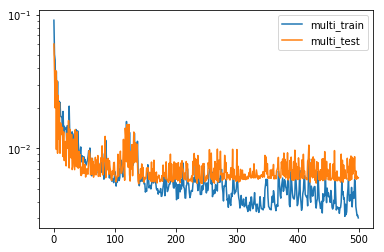

In [4]:
pyplot.plot(history.history['loss'], label='multi_train')
pyplot.plot(history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.yscale('log')
pyplot.show()

In [4]:
def create_model():
    Inp = Input(shape=(20,8))
    inp = Inp
    D = [1,2,4]
    for i in range(3):
        inp=tcn(inp,dilation_rate=D[i])
        #inp = BatchNormalization()(inp)
        #inp = Activation('relu')(inp)
    inp=Flatten()(inp)
    out=Dense(1)(inp)
    model = Model(Inp,out)
    ad = optimizers.Adam(lr=0.0002)
    model.compile(loss='mae', optimizer=ad)
    return model

C:\Users\aalahgholipour160413\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



0.8076923076923077


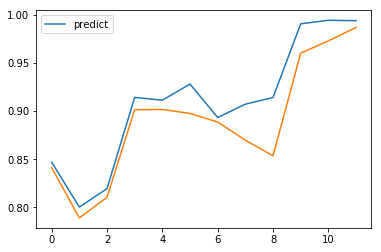

In [5]:
stock='AAPL'
model=create_model()
model.load_weights(stock+'.h5')
scaled, X, y, train_X, train_y, test_X, test_y = preprocess(stock,'2001-06-27','Close',20)
pred = model.predict([X[180:]])
diff1=np.concatenate((np.ediff1d(y[180:]).reshape(len(y[180:])-1,1),np.ediff1d(pred[:,0]).reshape(len(pred[:])-1,1)),axis=1)
mul = np.multiply(diff1[:,0],diff1[:,1])
model_accuracy = len(mul[mul>=0])/len(mul)
print(model_accuracy)
pyplot.plot(pred[-12:,:].reshape(12,1),label='predict')
pyplot.plot(y[-12:].reshape(12,1))
pyplot.legend()
pyplot.show()


In [9]:
data_gen = TimeseriesGenerator(scaled, scaled[:,-1],
                               length=20, sampling_rate=1,
                               stride=1, batch_size=len(scaled),shuffle=True)
X2, y2 = data_gen[0]
pred2 = model.predict([X2[:]])
diff2=np.concatenate((np.ediff1d(y2[:]).reshape(len(y2[:])-1,1),np.ediff1d(pred2[:,0]).reshape(len(pred2[:])-1,1)),axis=1)
mul2 = np.multiply(diff2[:,0],diff2[:,1])
model_accuracy2 = len(mul2[mul2>=0])/len(mul2)
model_accuracy2

0.9886555636012552

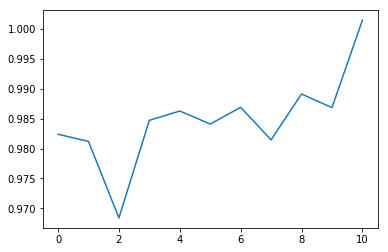

In [7]:
pyplot.plot(np.append(scaled[-10:,-1],model.predict(scaled[-20:].reshape(1,20,8))))
pyplot.show()

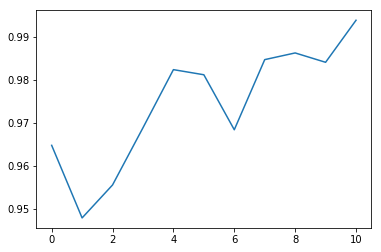

In [8]:
pyplot.plot(np.append(scaled[-14:-4,-1],model.predict(scaled[-24:-4].reshape(1,20,8))))
pyplot.show()